# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву. Данные можно скачать [тут](https://www.kaggle.com/c/hseds-texts-2020/data?select=train.csv).

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 1. В противном случае мы будем вынуждены не засчитать задание :( 

Для измерения качества вашей модели используйте разбиение данных на train и test и замеряйте качество на тестовой части.

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Удачи! 💪

#### Использовать внешние данные для обучения строго запрещено. Можно использовать предобученные модели из torchvision.

##### Скачать данные

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle competitions download -c hseds-texts-2020

  0% 0.00/8.78M [00:00<?, ?B/s]
100% 8.78M/8.78M [00:00<00:00, 146MB/s]
  0% 0.00/723k [00:00<?, ?B/s]
100% 723k/723k [00:00<00:00, 233MB/s]
  0% 0.00/1.75M [00:00<?, ?B/s]
100% 1.75M/1.75M [00:00<00:00, 240MB/s]


In [4]:
! mkdir hseds-texts-2020
! unzip train.csv.zip -d hseds-texts-2020
! unzip test.csv.zip -d hseds-texts-2020

Archive:  train.csv.zip
  inflating: hseds-texts-2020/train.csv  
Archive:  test.csv.zip
  inflating: hseds-texts-2020/test.csv  


##### Задачи

In [5]:
PATH_TO_TRAIN_DATA = 'hseds-texts-2020/train.csv'

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


In [7]:
test_data = pd.read_csv('hseds-texts-2020/test.csv')
test_data.head()

,review_id,negative,positive
0,00026f564b258ad5159aab07c357c4ca,Other than the location everything else was h...,Just the location
1,000278c73da08f4fcb857fcfe4ac6417,No UK TV but this was a minor point as we wer...,Great location very comfortable clean breakfa...
2,000404f843e756fe3b2a477dbefa5bd4,A tiny noisy room VERY deceptively photographed,The breakfast booked the preceding night but ...
3,000a66d32bcf305148d789ac156dd512,Noisy various electrical devices kicking in r...,Great location Nice bathroom
4,000bf1d8c5110701f459ffbedbf0d546,No Negative,Great location and friendly staff


Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [8]:
import string

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize


# Добавим стеммер
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer

lancaster = LancasterStemmer()
# porter = PorterStemmer()

# Стоп-слова
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english')) 

# Немножко переопределим функцию
def process_text(text, stem = True):
    if stem:
        text = ' '.join([lancaster.stem(word) for word in word_tokenize(text.lower())\
                  if (word not in string.punctuation) and (word not in stop_words)])
    else:
        text = ' '.join([word for word in word_tokenize(text.lower())\
                  if (word not in string.punctuation) and (word not in stop_words)])
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
from tqdm.notebook import tqdm
tqdm.pandas()

df['negative'] = df['negative'].progress_apply(process_text)
df['positive'] = df['positive'].progress_apply(process_text)

In [10]:
test_data['negative'] = test_data['negative'].progress_apply(process_text)
test_data['positive'] = test_data['positive'].progress_apply(process_text)

In [11]:
# Склеим, чтобы предсказывать
df['review'] = df.progress_apply(lambda x: x['negative'] + ' ' + x['positive'], axis = 1)
df.head()

,review_id,negative,positive,score,review
0,00003c6036f30f590c0ac435efb8739b,issu wif connect,posit,7.1,issu wif connect posit
1,00004d18f186bf2489590dc415876f73,tv work,posit,7.5,tv work posit
2,0000cf900cbb8667fad33a717e9b1cf4,pillow,beauty room gre loc lov staff,10.0,pillow beauty room gre loc lov staff
3,0000df16edf19e7ad9dd8c5cd6f6925e,busy,loc,5.4,busy loc
4,00025e1aa3ac32edb496db49e76bbd00,room could bit refurb could corrid lead bedroo...,nic breakfast handy victor train stat sights a...,6.7,room could bit refurb could corrid lead bedroo...


In [12]:
test_data['review'] = test_data.progress_apply(lambda x: x['negative'] + ' ' + x['positive'], axis = 1)

In [13]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)

### Часть 1. 1 балл

Обучите логистическую регрессию на TF-IDF векторах текстов.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as MAE

import matplotlib.pyplot as plt

%matplotlib inline

In [28]:
# ТФ-ИДФ
vectorizer = TfidfVectorizer(min_df=2e-5, # отрубим шумные слова
                             )

vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=2e-05, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [29]:
# Добываем фичи
X = vectorizer.fit_transform(df_train['review'])
print(X.shape)
X_test = vectorizer.transform(df_test['review'])

(75000, 9131)


In [26]:
# Лин. регрессия
linRegr = LinearRegression(normalize=True)
linRegr.fit(X, df_train['score'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [27]:
pred = linRegr.predict(X_test)
print('Mean Absolute Error:', MAE(df_test['score'], pred))

Mean Absolute Error: 0.9574915298833553


In [ ]:
#@title OLD
"""
corpus = []
for i in df['negative']:
    corpus += i
for i in df['positive']:
    corpus += i

print('Text size:', len(corpus))
print('Vocabulary size:', len(set(corpus)))


def make_dictionaries(text):
    words, counts = np.unique(text, return_counts=True)
    words = words[counts >= 5]
    words = words[np.argsort(-counts[counts >= 5])]
    int_to_vocab = {ii: word for ii, word in enumerate(words)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}
    
    return int_to_vocab, vocab_to_int


int_to_vocab, vocab_to_int = make_dictionaries(corpus)
"""

### Часть 2. 3 балла

Обучите логистическую регрессию на усредненных Word2Vec векторах.

> Блок с отступами



In [30]:
# Обучим Word2Vec вектора
from gensim.models import Word2Vec


def preprocess_for_w2v(text):
    return [word for word in text.split()]

latent_dim = 100
"""
w2v = Word2Vec(pd.concat([df['positive'],
                          df['negative'],
                          test_data['positive'],
                          test_data['negative']]).progress_apply(preprocess_for_w2v),
               min_count=0, sg=1, size = latent_dim) # skip-gram
"""
w2v = Word2Vec(pd.concat([df['review'],
                          test_data['review']]).progress_apply(preprocess_for_w2v),
               min_count=0, sg=1, size = latent_dim) # skip-gram

In [31]:
def sentense2vec(s, w2v, idf = None):
    vec = np.array([w2v[word] for word in s.split()])
    n = len(vec)
    if n == 0:
        latent_dim = w2v['posit'].shape[0]
        vec = np.zeros((1, latent_dim))
        return vec
    if idf:
        weights = np.array([idf[word] for word in s.split()])
        # weights /= np.sum(weights) # ухудшает(
        vec *= weights.reshape(n, -1)
        return (np.sum(vec, axis = 0) / n).reshape(1, -1)
    else:
        return np.mean(vec, axis = 0).reshape(1, -1)

In [32]:
X_mean = df_train['review'].progress_apply(lambda x: sentense2vec(x, w2v))
X_mean = np.concatenate(np.array(X_mean))
X_mean.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(75000, 100)

In [34]:
# Лин. регрессия на усредненных Word2Vec векторах
linRegr_mean = LinearRegression()
linRegr_mean.fit(X_mean, df_train['score'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
X_mean_test = df_test['review'].progress_apply(lambda x: sentense2vec(x, w2v))
X_mean_test = np.concatenate(np.array(X_mean_test))
X_mean_test.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(25000, 100)

In [36]:
pred = linRegr_mean.predict(X_mean_test)
print('Mean Absolute Error:', MAE(df_test['score'], pred))

Mean Absolute Error: 0.9915355109251763


In [197]:
lat_dims = [2, 16, 32, 64, 128, 256, 512, 1024, 2048]
res = []
for dim in tqdm(lat_dims):
    w2v = Word2Vec(pd.concat([df['review'],
                              test_data['review']]).apply(preprocess_for_w2v),
                  min_count=0, sg=1, size = dim) # skip-gram
    
    X_mean = df_train['review'].apply(lambda x: sentense2vec(x, w2v))
    X_mean = np.concatenate(np.array(X_mean))

    X_mean_test = df_test['review'].apply(lambda x: sentense2vec(x, w2v))
    X_mean_test = np.concatenate(np.array(X_mean_test))

    linRegr_mean = LinearRegression()
    linRegr_mean.fit(X_mean, df_train['score'])

    pred = linRegr_mean.predict(X_mean_test)
    res.append(MAE(df_test['score'], pred))
    print('Mean Absolute Error:', MAE(df_test['score'], pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.7160990674548238


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.6401625164233785


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.6197036716856373


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.6053283111516095


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.5997518197358378


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.5905113193077856


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.5846624803912623


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.5830077031228832


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.583940927454045



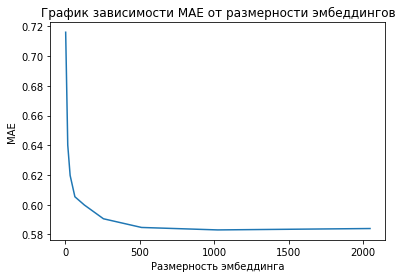

In [198]:
# (МАE на отнормированном score)
plt.plot(lat_dims, res)
plt.title('График зависимости MAE от размерности эмбеддингов')
plt.xlabel('Размерность эмбеддинга')
plt.ylabel('MAE')
plt.show()

Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [37]:
def calc_idf(texts):
    ndoc = len(texts)
    idf_cnt = dict()
    for doc in tqdm(texts):
        for word in set(doc.split(' ')):
            idf_cnt[word] = idf_cnt.get(word, 0) + 1
    for word in idf_cnt:
        idf_cnt[word] = np.log(ndoc / idf_cnt[word])

    return idf_cnt


idf_cnt = calc_idf(pd.concat([df['review'], test_data['review']]))

In [38]:
X_avg = df_train['review'].progress_apply(lambda x: sentense2vec(x, w2v, idf_cnt))
X_avg = np.concatenate(np.array(X_avg))
X_avg.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(75000, 100)

In [39]:
# Лин. регрессия на средневзвешенных Word2Vec векторах
linRegr_avg = LinearRegression()
linRegr_avg.fit(X_avg, df_train['score'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
X_avg_test = df_test['review'].progress_apply(lambda x: sentense2vec(x, w2v, idf_cnt))
X_avg_test = np.concatenate(np.array(X_avg_test))
X_avg_test.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(25000, 100)

In [41]:
# Ну прям супермаленький прирост качества (или вовсе нет (или хуже) в зависимости от сида)
pred = linRegr_avg.predict(X_avg_test)
print('Mean Absolute Error:', MAE(df_test['score'], pred))

Mean Absolute Error: 0.9946534159879269


In [195]:
lat_dims = [2, 16, 32, 64, 128, 256, 512, 1024, 2048]
res = []
for dim in tqdm(lat_dims):
    w2v = Word2Vec(pd.concat([df['review'],
                              test_data['review']]).apply(preprocess_for_w2v),
                  min_count=0, sg=1, size = dim) # skip-gram
    
    X_avg = df_train['review'].apply(lambda x: sentense2vec(x, w2v, idf_cnt))
    X_avg = np.concatenate(np.array(X_avg))

    X_avg_test = df_test['review'].apply(lambda x: sentense2vec(x, w2v, idf_cnt))
    X_avg_test = np.concatenate(np.array(X_avg_test))

    linRegr_avg = LinearRegression()
    linRegr_avg.fit(X_avg, df_train['score'])

    pred = linRegr_avg.predict(X_avg_test)
    res.append(MAE(df_test['score'], pred))
    print('Mean Absolute Error:', MAE(df_test['score'], pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.7211021225057375


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.6348705254879531


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.6177049128827402


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.609129500322133


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.6004665029798865


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.5921093907126951


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.5836593663068019


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.5827364356747152


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Mean Absolute Error: 0.5845531042548205



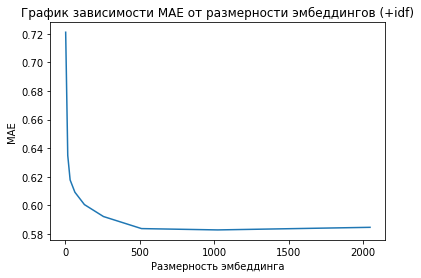

In [196]:
# (МАE на отнормированном score)
plt.plot(lat_dims, res)
plt.title('График зависимости MAE от размерности эмбеддингов (+idf)')
plt.xlabel('Размерность эмбеддинга')
plt.ylabel('MAE')
plt.show()

Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 
#### Сделайте выводы:

Получилось так, что обычная линейная регрессия, обученная на tf-idf векторах показывает более качественные результаты, чем на усредненных word2vec векторах предложений. Более того, взвешивание слов в предложении с помощью idf дает низкий прирост в качестве - буквально, десятитысячные доли MAE (или не дает вовсе). 

Увеличение размерности эмбеддингов дает заметный прирост в качестве, однако при размерности более 1024 можно наблюдать увеличение MAE, что, вероятно, свидетельствует о переобучении word2vec. 

Теперь попробуйте обучить логистическую регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.
#### Выводы:

In [42]:
# Google's pre-trained Word2Vec
import gensim.downloader


model = gensim.downloader.load('word2vec-google-news-300')

[================================================--] 96.8% 1609.0/1662.8MB downloaded


In [43]:
def sentense2vec(s, model, idf = None):
    vec = []
    for word in s.split():
        if word in model.vocab:
            vec.append(model[word])
        elif lancaster.stem(word) in model.vocab:
            vec.append(model[lancaster.stem(word)])
        else:
            vec.append(np.zeros_like(model['posit']))
    vec = np.array(vec)
    n = len(vec)
    if n == 0:
        latent_dim = model['posit'].shape[0]
        vec = np.zeros((1, latent_dim))
        return vec
    if idf:
        weights = np.array([idf[word] for word in s.split()])
        # weights /= np.sum(weights) # ухудшает(
        vec *= weights.reshape(n, -1)
        return (np.sum(vec, axis = 0) / n).reshape(1, -1)
    else:
        return np.mean(vec, axis = 0).reshape(1, -1)

In [44]:
# Уберем стемминг
df = pd.read_csv(PATH_TO_TRAIN_DATA)
test_data = pd.read_csv('hseds-texts-2020/test.csv')

df['negative'] = df['negative'].progress_apply(lambda x: process_text(x, False))
df['positive'] = df['positive'].progress_apply(lambda x: process_text(x, False))

test_data['negative'] = test_data['negative'].progress_apply(lambda x: process_text(x, False))
test_data['positive'] = test_data['positive'].progress_apply(lambda x: process_text(x, False))

df['review'] = df.progress_apply(lambda x: x['negative'] + ' ' + x['positive'], axis = 1)
test_data['review'] = test_data.progress_apply(lambda x: x['negative'] + ' ' + x['positive'], axis = 1)

In [ ]:
df_train, df_test = train_test_split(df)

In [46]:
idf_cnt = calc_idf(pd.concat([df['review'], test_data['review']]))

In [47]:
X = df_train['review'].apply(lambda x: sentense2vec(x, model, idf_cnt))
X = np.concatenate(np.array(X))

X_test = df_test['review'].apply(lambda x: sentense2vec(x, model, idf_cnt))
X_test = np.concatenate(np.array(X_test))

linRegr = LinearRegression()
linRegr.fit(X, df_train['score'])

pred = linRegr.predict(X_test)
print('Mean Absolute Error:', MAE(df_test['score'], pred))

Mean Absolute Error: 1.0328177928534927


Даже несмотря на то, что гугловский w2v обучался на невероятно большом корпусе текстов, он не дает значительного роста в качестве и даже уступает обученному на данном датасете w2v.

### Часть 3. 6 баллов

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

#### Preprocessing

In [40]:
df['positive'] = df['positive'].apply(lambda x: x.split())
df['negative'] = df['negative'].apply(lambda x: x.split())
df['review'] = df['review'].apply(lambda x: x.split())
df_train['positive'] = df_train['positive'].apply(lambda x: x.split())
df_train['negative'] = df_train['negative'].apply(lambda x: x.split())
df_train['review'] = df_train['review'].apply(lambda x: x.split())
df_test['positive'] = df_test['positive'].apply(lambda x: x.split())
df_test['negative'] = df_test['negative'].apply(lambda x: x.split())
df_test['review'] = df_test['review'].apply(lambda x: x.split())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

#### Задание

Позаимствуем код отсюда [ТЫК](https://pytorch.org/tutorials/beginner/transformer_tutorial.html), а также с семинара 11

In [41]:
import torch
from torch import nn
from torch.nn import functional as F

In [60]:
WORDS = set()
for sent in list(df['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df['negative']):
    for w in sent:
        WORDS.add(w)

In [61]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [92]:
MAX_LEN = max(max(df['positive'].apply(len)), max(df['negative'].apply(len)))
MAX_LEN

In [94]:
from torch.nn.utils.rnn import pad_sequence

train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df_train['positive']], 
                           batch_first=True)

In [95]:
MAX_LEN = max(df['review'].apply(len))
MAX_LEN

340

In [96]:
train_reviews = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df_train['review']], 
                           batch_first=True)

test_reviews = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df_test['review']], 
                           batch_first=True)

In [107]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        ## TODO
        self._tokens, self.targets  = df[0], df[1]

    def __len__(self):
        ## TODO
        return len(self._tokens)
    
    def __getitem__(self, idx: int):
        ## TODO
        return self._tokens[idx], torch.as_tensor(self.targets[idx])

In [119]:
BATCH_SIZE = 1

train_dataset = ReviewsDataset((train_reviews, np.array(df_train['score'])))
test_dataset = ReviewsDataset((test_reviews, np.array(df_test['score'])))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [182]:
embedding = nn.Embedding(len(word2int), 512)
embedding.cuda()

Embedding(21375, 512)

In [270]:
class MyLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, seq_lenght):
        super(MyLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, )

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim * seq_lenght, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence).transpose(0, 1)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out.transpose(0, 1).view(-1, lstm_out.shape[0] * lstm_out.shape[2]))
        return tag_space

In [272]:
model = MyLSTM(512, 512, len(word2int), 1, MAX_LEN)
model.cuda()

MyLSTM(
  (word_embeddings): Embedding(21375, 512)
  (lstm): LSTM(512, 512)
  (hidden2tag): Linear(in_features=174080, out_features=1, bias=True)
)

In [275]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [276]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    return_losses: bool = False,
):
    model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader)) as prbar:
        for batch in data_loader:
            # Move Batch to GPU
            inputs, targets = batch
            inputs, targets = inputs.cuda(), targets.cuda()
            # Get model results
            inputs = embedding(inputs).view(MAX_LEN, BATCH_SIZE, -1)
            output = model(inputs)
            loss = criterion(output, targets)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            prbar.set_description(f"Loss: {loss.item():.4f}")
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {"loss": total_loss / num_batches}
    if return_losses:
        return metrics, all_losses
    else:
        return metrics

In [ ]:
train_epoch(model, train_dataloader, optimizer)

In [ ]:
NUM_EPOCHS = 1

for n in range(NUM_EPOCHS):
    model.train()
    ## TODO

#### ЛСТМ плохо работает ( [Ссылка на код](https://simpletransformers.ai/docs/regression/)

In [ ]:
!pip install simpletransformers

In [16]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Preparing train data
train_df = df_train[['review', 'score']]
train_df.columns = ["text", "labels"]

# Preparing eval data
eval_df = df_test[['review', 'score']]
eval_df.columns = ["text", "labels"]

# Enabling regression
# Setting optional model configuration
model_args = ClassificationArgs()
model_args.num_train_epochs = 100
model_args.regression = True

# Create a ClassificationModel
model = ClassificationModel(
    "roberta",
    "roberta-base",
    num_labels=1,
    args=model_args
)

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

# Make predictions with the model
# predictions, raw_outputs = model.predict(["Sam was a Wizard"])

INFO:filelock:Lock 139976037710480 acquired on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


INFO:filelock:Lock 139976037710480 released on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


INFO:filelock:Lock 139977035777752 acquired on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


INFO:filelock:Lock 139977035777752 released on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

INFO:filelock:Lock 139976028364248 released on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock


INFO:filelock:Lock 139976028364248 acquired on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


INFO:filelock:Lock 139976028364248 released on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


KeyboardInterrupt: ignored

In [17]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'eval_loss': 1.394425804539919}


In [22]:
MAE(model_outputs, df_test['score'])

0.8325899531249998

Можно видеть, что предобученный роБЕРТ смог оставить позади другие методы :)

In [32]:
!rm -r outputs

In [30]:
model.train_model(train_df)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


KeyboardInterrupt: ignored

In [31]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
MAE(model_outputs, df_test['score'])

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4d70c52470>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


INFO:simpletransformers.classification.classification_model:{'eval_loss': 1.2271021384692191}


0.7831823906250002

In [33]:
model.train_model(train_df)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


KeyboardInterrupt: ignored

In [34]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
MAE(model_outputs, df_test['score'])

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f4e28160978>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


INFO:simpletransformers.classification.classification_model:{'eval_loss': 1.39798102409482}


0.8271165624999999

### Бонус. 10 баллов

Побейте качество 0.75 в [соревновании](https://www.kaggle.com/c/hseds-texts-2020/leaderboard). Можете воспользоваться вышеперечисленными методами или попробовать что-нибудь еще.

#### Word2vec

In [128]:
w2v = Word2Vec(pd.concat([df['review'],
                          test_data['review']]).progress_apply(preprocess_for_w2v),
               min_count=0, sg=1, size = 1024) # skip-gram

In [133]:
idf_cnt = calc_idf(pd.concat([df['review'], test_data['review']]))

X = df['review'].progress_apply(lambda x: sentense2vec(x, w2v, idf_cnt))
X = np.concatenate(np.array(X))

X_submit = test_data['review'].progress_apply(lambda x: sentense2vec(x, w2v, idf_cnt))
X_submit = np.concatenate(np.array(X_submit))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [150]:
# Нормируем оценки
y_std = np.std(df['score'])
y_mean = np.mean(df['score'])
print(y_mean, y_std)
y = (df['score'] - y_mean) / y_std
print(y.shape)

8.398282999999289 1.6391724594770352
(100000,)


In [151]:
linRegr = LinearRegression()
linRegr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [152]:
pred = np.clip(linRegr.predict(X_submit) * y_std + y_mean, 0, 10)
pred = pd.concat([test_data['review_id'], pd.Series(pred)], axis = 1)
pred.columns = ['review_id', 'score']
pred.head()

,review_id,score
0,00026f564b258ad5159aab07c357c4ca,6.269822
1,000278c73da08f4fcb857fcfe4ac6417,9.668418
2,000404f843e756fe3b2a477dbefa5bd4,6.086690
3,000a66d32bcf305148d789ac156dd512,6.826086
4,000bf1d8c5110701f459ffbedbf0d546,9.555031


In [153]:
pred.to_csv("submission.csv", index=False)

#### Линейная регрессия

In [ ]:
# ТФ-ИДФ
vectorizer = TfidfVectorizer(min_df=2e-5, # отрубим шумные слова
                             )

# Считаем статистики для нормировки
y_std = np.std(df['score'])
y_mean = np.mean(df['score'])
print(y_mean, y_std)
vectorizer

8.398282999999289 1.6391724594770352


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=2e-05, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
# Добываем фичи
X = vectorizer.fit_transform(df['review'])
print(X.shape)
# Нормируем оценки
y = (df['score'] - y_mean) / y_std
print(y.shape)

(100000, 10476)
(100000,)


In [ ]:
# Лин. регрессия
linRegr = LinearRegression()
linRegr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Предсказания

In [ ]:
X_submit = vectorizer.transform(test_set['review'])

pred = np.clip(linRegr.predict(X_submit) * y_std + y_mean, 0, 10)
pred = pd.concat([test_set['review_id'], pd.Series(pred)], axis = 1)
pred.columns = ['review_id', 'score']
pred.head()

,review_id,score
0,00026f564b258ad5159aab07c357c4ca,5.070777
1,000278c73da08f4fcb857fcfe4ac6417,10.000000
2,000404f843e756fe3b2a477dbefa5bd4,6.310255
3,000a66d32bcf305148d789ac156dd512,6.393921
4,000bf1d8c5110701f459ffbedbf0d546,9.640399


In [ ]:
pred.to_csv("submission.csv", index=False)